# TEST image & coordinates grid rotation

In [1]:
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.math as afwMath
import lsst.geom as geom
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
import astropy.visualization as vis
import gc

In [2]:
#Set afwDisplay to use matplotlib, and use colorblind-friendly colors.
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

Function rotate_exposure from DP02_14_Injecting_Synthetic_Sources - a modified version of [this code](https://github.com/lsst/atmospec/blob/1e7d6e8e5655cc13d71b21ba866001e6d49ee04e/python/lsst/atmospec/utils.py#L259-L301).

In [3]:
def rotate_exposure(exp, n_degrees):
    """Rotate an exposure by nDegrees clockwise.

    Parameters
    ----------
    exp : `lsst.afw.image.exposure.Exposure`
        The exposure to rotate
    n_degrees : `float`
        Number of degrees clockwise to rotate by

    Returns
    -------
    rotated_exp : `lsst.afw.image.exposure.Exposure`
        A copy of the input exposure, rotated by nDegrees
    """
    n_degrees = n_degrees % 360

    wcs = exp.getWcs()

    warper = afwMath.Warper('lanczos4')

    affine_rot_transform = geom.AffineTransform.makeRotation(n_degrees*geom.degrees)
    transform_p2top2 = afwGeom.makeTransform(affine_rot_transform)
    rotated_wcs = afwGeom.makeModifiedWcs(transform_p2top2, wcs, False)

    rotated_exp = warper.warpExposure(rotated_wcs, exp)
    return rotated_exp

In [4]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

I arbitrarily define an image and extract useful info

In [5]:
dataId = {'instrument': 'LSSTCam-imSim', 'detector': 60, 'visit': 964209, 'band': 'g', 'physical_filter': 'r_sim_1.4'}

In [6]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
image = butler.get("calexp", dataId=dataId)

In [7]:
visitInfo = butler.get("calexp.visitInfo", dataId=dataId)
print(visitInfo)

VisitInfo(exposureTime=30, darkTime=30, date=2025-11-19T05:15:08.140899939, UT1=nan, ERA=2.38746 rad, boresightRaDec=(57.0910540010, -34.6558679005), boresightAzAlt=(238.3930420731, +80.9489061026), boresightAirmass=1.01108, boresightRotAngle=2.03788 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(nan, nan, 40), instrumentLabel='LSSTCam-imSim', id=964209, focusZ=nan, observationType='SKYEXP', scienceProgram='', observationReason='', object='', hasSimulatedContent=false)


In [8]:
bbox = image.getBBox()
wcs = image.getWcs()
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
c = SkyCoord(ra=center.getRa().asDegrees()*u.degree,
             dec=center.getDec().asDegrees()*u.degree, frame='icrs')
print("Image center RA in h:m:s format is:", c.ra.hms)
print("Image center De in deh:m:s format is:", c.dec)

Image center RA in h:m:s format is: hms_tuple(h=np.float64(3.0), m=np.float64(47.0), s=np.float64(21.00701989921518))
Image center De in deh:m:s format is: -34d01m23.96094562s


I rotate the field to have  North up and East at the left (so RA along x-axis and DEC along y-axis, with RA increasing to the left and Dec increasing towards the top

In [9]:
#How to retrieve rotation angle. da https://community.lsst.org/t/calexps-displayed-with-imshow-seem-offset-from-wcs-center/9475
#print(calexp.getInfo().getVisitInfo().boresightRotAngle.asDegrees())
rotationangle = image.getInfo().getVisitInfo().boresightRotAngle.asDegrees()
print("Image rotation angle = " + str(rotationangle) + " deg")

Image rotation angle = 116.76168911185 deg


In [10]:
myrotationangle = 360- rotationangle   # to "derotate" the field <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                                       # or simply  myrotationangle = -rotationangle
print("my rotation angle = " + str(myrotationangle))

my rotation angle = 243.23831088815


In [11]:
rotation_angle = myrotationangle #243
image_rotated = rotate_exposure(image, rotation_angle)

I check the center of the rotated images and I compare it with the original image center, it's the same

In [12]:
bbox_rotated = image_rotated.getBBox()
wcs_rotated = image_rotated.getWcs()
center_rotated = wcs_rotated.pixelToSky(bbox_rotated.centerX, bbox_rotated.centerY)
c_rotated = SkyCoord(ra=center_rotated.getRa().asDegrees()*u.degree,
             dec=center_rotated.getDec().asDegrees()*u.degree, frame='icrs')
print("Rotated Image center RA in h:m:s format is:", c_rotated.ra.hms)
print("Rotated Image center De in deh:m:s format is:", c_rotated.dec)
print("Image center RA in h:m:s format is:", c.ra.hms)
print("Image center De in deh:m:s format is:", c.dec)

Rotated Image center RA in h:m:s format is: hms_tuple(h=np.float64(3.0), m=np.float64(47.0), s=np.float64(21.001003828125988))
Rotated Image center De in deh:m:s format is: -34d01m23.88806291s
Image center RA in h:m:s format is: hms_tuple(h=np.float64(3.0), m=np.float64(47.0), s=np.float64(21.00701989921518))
Image center De in deh:m:s format is: -34d01m23.96094562s


In [13]:
print(wcs)
print(" --- ")
print(image.getWcs())
print(" --- ")
print(" --- ")
print(wcs_rotated)
print(" --- ")
print(image_rotated.getWcs())

FITS standard SkyWcs:
Sky Origin: (56.8459142679, -34.0243490504)
Pixel Origin: (2075.31, 2119.48)
Pixel Scale: 0.200031 arcsec/pixel
 --- 
FITS standard SkyWcs:
Sky Origin: (56.8459142679, -34.0243490504)
Pixel Origin: (2075.31, 2119.48)
Pixel Scale: 0.200031 arcsec/pixel
 --- 
 --- 
FITS standard SkyWcs:
Sky Origin: (56.8459142679, -34.0243490504)
Pixel Origin: (-2826.93, 898.658)
Pixel Scale: 0.200031 arcsec/pixel
 --- 
FITS standard SkyWcs:
Sky Origin: (56.8459142679, -34.0243490504)
Pixel Origin: (-2826.93, 898.658)
Pixel Scale: 0.200031 arcsec/pixel


Plot of the field in pixel

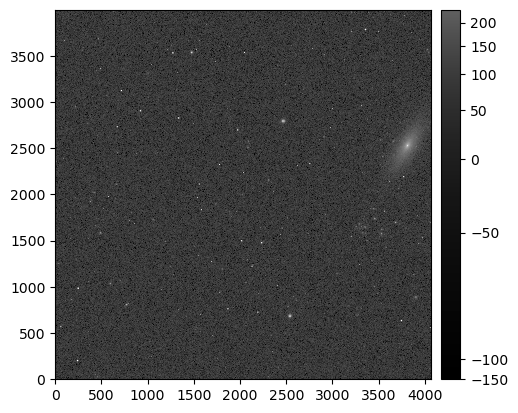

In [14]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(image.image)
plt.show()
remove_figure(fig)

plot of the field in celestial coordinates

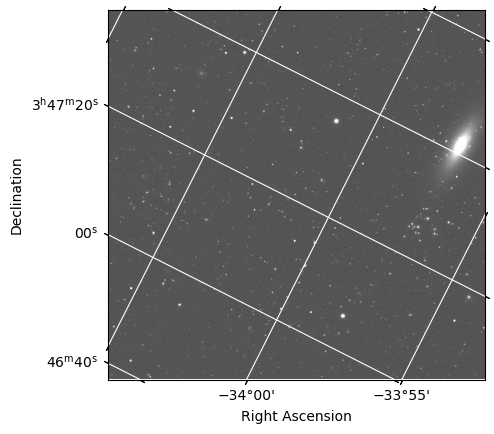

In [15]:
fig = plt.figure()
plt.subplot(projection=WCS(image.getWcs().getFitsMetadata()))
image_extent = (image.getBBox().beginX, image.getBBox().endX,
                 image.getBBox().beginY, image.getBBox().endY)
im = plt.imshow(image.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=image_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
#plt.savefig("original_corr.png")
remove_figure(fig)

plot of the rotated field in celestial coordinates

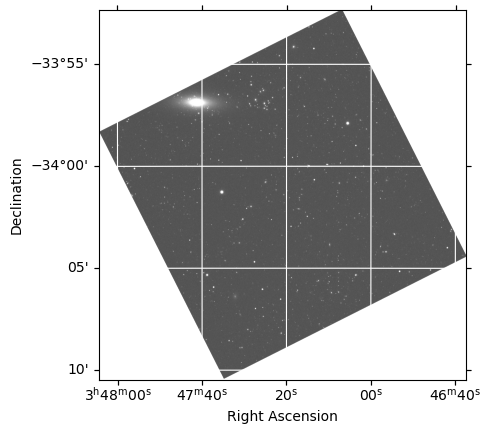

In [16]:
fig = plt.figure()
plt.subplot(projection=WCS(image_rotated.getWcs().getFitsMetadata()))
image_rotated_extent = (image_rotated.getBBox().beginX, image_rotated.getBBox().endX,
                 image_rotated.getBBox().beginY, image_rotated.getBBox().endY)
im = plt.imshow(image_rotated.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=image_rotated_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
#plt.savefig("rotated_1corr.png")
remove_figure(fig)

I define the coordinates of a clearly identifiable object in the field (a galaxy)

In [17]:
coord_gal = SkyCoord(
    ra = 56.9223016 * u.degree,  #3h 47m 41.35s
    dec = -33.9485169 * u.degree, #-33 56 54.66
    frame='icrs'
)

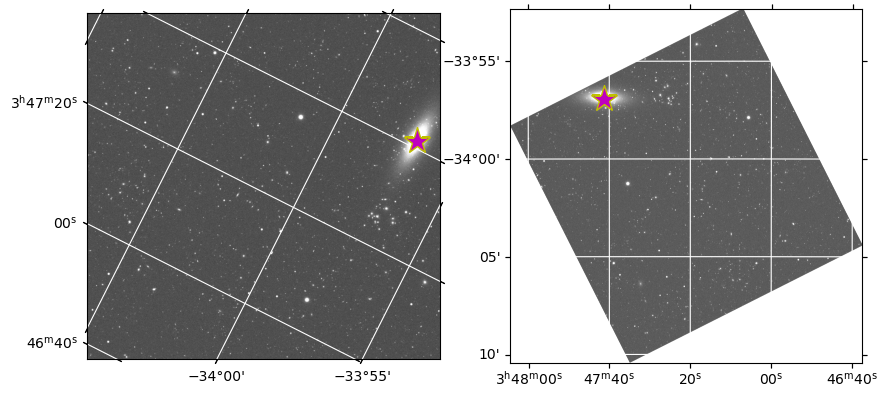

In [18]:
#plot of the original and rotated image side by side, marking the selected galaxy

zscale = vis.ZScaleInterval()

fig = plt.figure(figsize=(10, 5))

wcs = WCS(image.getWcs().getFitsMetadata())
image_data = image.getImage().array
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}

wcs_rotated = WCS(image_rotated.getWcs().getFitsMetadata())
image_rotated_data = image_rotated.getImage().array
limits_rotated = {"vmin": (_lims := zscale.get_limits(image_rotated_data))[0], "vmax": _lims[1]}


ax = fig.add_subplot(1, 2, 1, projection=wcs)
ax.imshow(image_data, cmap='gray', **limits, extent=image_extent)
ax.plot(*wcs.world_to_pixel(coord_gal), 'y*', markerfacecolor="m", ms=20, label="Candidate transient coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')

ax = fig.add_subplot(1, 2, 2, projection=wcs_rotated)
ax.imshow(image_rotated_data, cmap='gray', **limits_rotated, extent=image_rotated_extent )
ax.plot(*wcs_rotated.world_to_pixel(coord_gal), 'y*', markerfacecolor="m", ms=20, label="Candidate transient coordinates")
ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(''); ax.set_ylabel('')
plt.grid(color='white', ls='solid')
plt.show()
#plt.savefig("rotated_2corr.png")
remove_figure(fig)